In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np

/home/rajeckidoyle/miniconda3/envs/my_torch_geometric/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_reverse_split_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
train_dataset = FingerprintDataset(split='train')
test_dataset = FingerprintDataset(split='test')

In [4]:
#Specify device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = best_config.GLOBALPARAMETERS['valid_size']

In [6]:
#Get Model Parameters
hyperparameters = eval('best_config.'+'MLP_MLE_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

## Define Model

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model_params

{'has_edge_info': False,
 'batch_size': 64,
 'learning_rate': 0.000138,
 'model_layers': 3,
 'model_embedding_size': 128,
 'model_dense_neurons': 64,
 'model_linear_dropout_rate': 0.078,
 'model_embedding_dropout_rate': 0.119,
 'feature_size': 1024}

In [9]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP_MLE(
  (conv_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (initial_conv): Linear(in_features=1024, out_features=128, bias=True)
  (embedding_dropout): Dropout(p=0.119, inplace=False)
  (linear_dropout): Dropout(p=0.078, inplace=False)
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=1, bias=True)
  (readout2): Linear(in_features=128, out_features=64, bias=True)
  (var): Linear(in_features=64, out_features=1, bias=True)
)
181378


In [10]:
model = model.to(device)

In [11]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=0.0001)  

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [12]:
class Engine:
    def __init__(self, model, model_params, optimizer, device):
        self.model = model
        self.model_params = model_params
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = torch.nn.GaussianNLLLoss()

    def train(self, loader):
        self.model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):  
            self.optimizer.zero_grad()
            fingerprint = fingerprint.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            mu, var = self.model(fingerprint)
            loss = self.loss_fn(mu, labels, var)
            # Backward and optimize
            final_loss += loss.item()
            loss.backward()
            self.optimizer.step() 
        return final_loss / len(loader)
    
    def evaluate(self, loader):
            self.model.eval()
            # Enumerate over the data
            final_loss = 0
            for i, (fingerprint, labels) in enumerate(loader):  
                fingerprint = fingerprint.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                mu, var = self.model(fingerprint)
                loss = self.loss_fn(mu, labels, var)
                final_loss += loss.item()
            return final_loss / len(loader)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

eng = Engine(model, model_params, optimizer, device)

print("Starting training...")
losses = []
for epoch in range(no_of_epochs):
    loss = eng.train(train_loader)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 22.298431597257917
Epoch 10 | Train Loss 3.067951051812423
Epoch 20 | Train Loss 1.6693914124840183
Epoch 30 | Train Loss 1.4219325529901605
Epoch 40 | Train Loss 1.1837761213904934
Epoch 50 | Train Loss 0.7951712608337402
Epoch 60 | Train Loss 0.5801834275847987
Epoch 70 | Train Loss 0.511479200501191
Epoch 80 | Train Loss 0.6939821666792819
Epoch 90 | Train Loss 0.45104108515538666
Epoch 100 | Train Loss 0.49798082521087245
Epoch 110 | Train Loss 0.39577235203040273
Epoch 120 | Train Loss 0.2967727270565535
Epoch 130 | Train Loss 0.2595456731750777
Epoch 140 | Train Loss 0.25453166276412575
Epoch 150 | Train Loss 0.21136845868865126
Epoch 160 | Train Loss 0.13795338433824086
Epoch 170 | Train Loss 0.12913032895640322
Epoch 180 | Train Loss 0.0837442529828925
Epoch 190 | Train Loss 0.11246119640571506


## Evaluate on the Test Set

In [14]:
import pandas as pd 
model.eval()
true_values = []
predictions = []
variance = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        mu, var = model(fingerprint)
        true_values += labels.tolist()
        predictions += mu.tolist()
        variance += var.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values, 'variance': variance})
df = df.applymap(lambda x : x[0])
df

,y_pred,y_real,variance
0,7.124595,7.301030,0.251700
1,6.289748,6.142667,0.293115
2,7.248589,7.443697,0.338207
3,7.865430,9.000000,0.878268
4,7.912282,8.698970,0.841239
...,...,...,...
298,4.644324,4.546682,0.249798
299,5.762573,6.568636,0.611176
300,6.910586,7.167491,0.565869
301,7.541218,7.774691,0.828692


In [24]:
df.to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/datasets/MLE.csv')

## Model Evaluation

In [15]:
from sklearn import metrics

In [16]:
mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
mae = metrics.mean_absolute_error(df["y_real"],df["y_pred"])
r = metrics.r2_score(df["y_real"],df["y_pred"])

mse, mae, r

(0.45344289589327674, 0.4907983679189147, 0.7615611410954888)

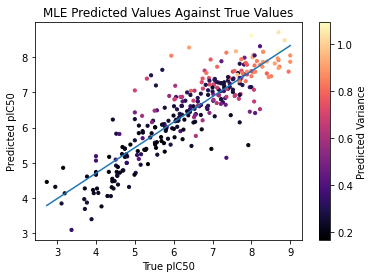

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data...
x = df["y_real"]
y = df["y_pred"]
color = df['variance']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

sc = plt.scatter(x, y, c=color, s=10, cmap='magma')
cbar = plt.colorbar(sc)
cbar.set_label('Predicted Variance')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('MLE Predicted Values Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/pvtMLE.jpeg', bbox_inches = 'tight', dpi=300)

In [18]:
rho = np.corrcoef(df['y_real'],df['variance'])[0,1]
rho

0.6279811472262452

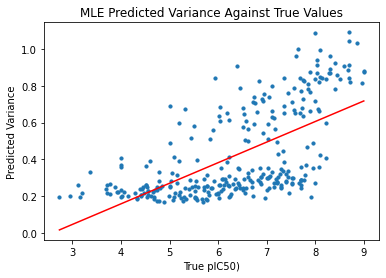

In [19]:
plt.scatter(df['y_real'], df['variance'], s=10)
plt.xlabel('True pIC50)')
plt.ylabel('Predicted Variance')
plt.plot(np.unique(df['y_real']), np.poly1d(np.polyfit(df['y_real'], df['variance'], 1))(np.unique(df['y_real'])), c='r')
plt.title('MLE Predicted Variance Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/varvtMLE.jpeg', bbox_inches = 'tight', dpi=300)

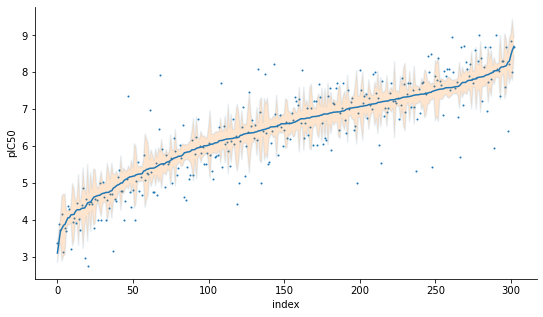

In [20]:
data_sorted_by_pred = df.sort_values('y_pred').reset_index()
# Define variables to plot
mu = data_sorted_by_pred['y_pred']
x = mu.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
y_std = df['variance']
error = y_std
lower = mu - error
upper = mu + error

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, data_sorted_by_pred['y_real'], label='pred mean', s=1)
ax.plot(x, mu, label='pred mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('index')
ax.set_ylabel('pIC50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [21]:
from sklearn import metrics
from scipy.stats import stats
def get_results(df):
    mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
    sc = stats.spearmanr(df["y_real"],df["y_pred"])[0]
    pc = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
    r = metrics.r2_score(df["y_real"],df["y_pred"])
    varcorr = np.corrcoef(df['y_real'], df['variance'])[0,1]

    results = {
        'Mean Square Error':mse,
        'Spearman':sc,
        'Pearson':pc,
        'R':r,
        'Variance Rho': varcorr,
    }
    results_df = pd.DataFrame([results])
    return results_df

get_results(df).to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/MLEresults.csv')

In [22]:
get_results(df)

,Mean Square Error,Spearman,Pearson,R,Variance Rho
0,0.453443,0.858556,0.874845,0.761561,0.627981
